In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical
from data import data_dirs as data_env

from result_visualization import show_results

from fastai.vision import (
    Learner, load_learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType,
    plt,   # matplotlib.pyplot
    nn,    # torch.nn
    optim  # torch.optim
)
from fastai.callbacks.mem import PeakMemMetric

from model import (
    decoder_high_output, decoder_middle_output, decoder_first_output,
    encoder_low_output, encoder_middle_output, encoder_first_output,
    LinkNet34, pre_encoder_output
)

from torchvision.utils import save_image

import cv2

import numpy as np

import imageio
from pathlib import Path

import torch
torch.set_printoptions(precision=7, sci_mode=False)

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
sizes= 256

test_data = (
    ImageList
    .from_folder(data_env.get_subdir("test iPhoneXR images"))
    .split_by_folder()
    .label_empty()
    .add_test_folder(test_folder="./")
    .transform(get_transforms(do_flip=False), size=sizes, resize_method=ResizeMethod.SQUISH)
    .databunch(bs=1)
    .normalize(imagenet_stats)
)

classes = 2

In [3]:
learner = load_learner("/home/dmitri/Documents/model_weights/linknet34/", "linknet34_osp_full_e25_exp_without_logit_1e-03")

# model = LinkNet34(num_classes=2)

# learner = Learner(test_data, model)
# learner.opt_fn = optim.Adam
# learner.loss_fn = nn.BCELoss()

# learner = learner.load("/home/dmitri/Documents/model_weights/linknet34/linknet34_osp_full_e25_wghts_without_logit", )

In [4]:
learner.model.save_decoder = True
learner.model.save_encoder = True

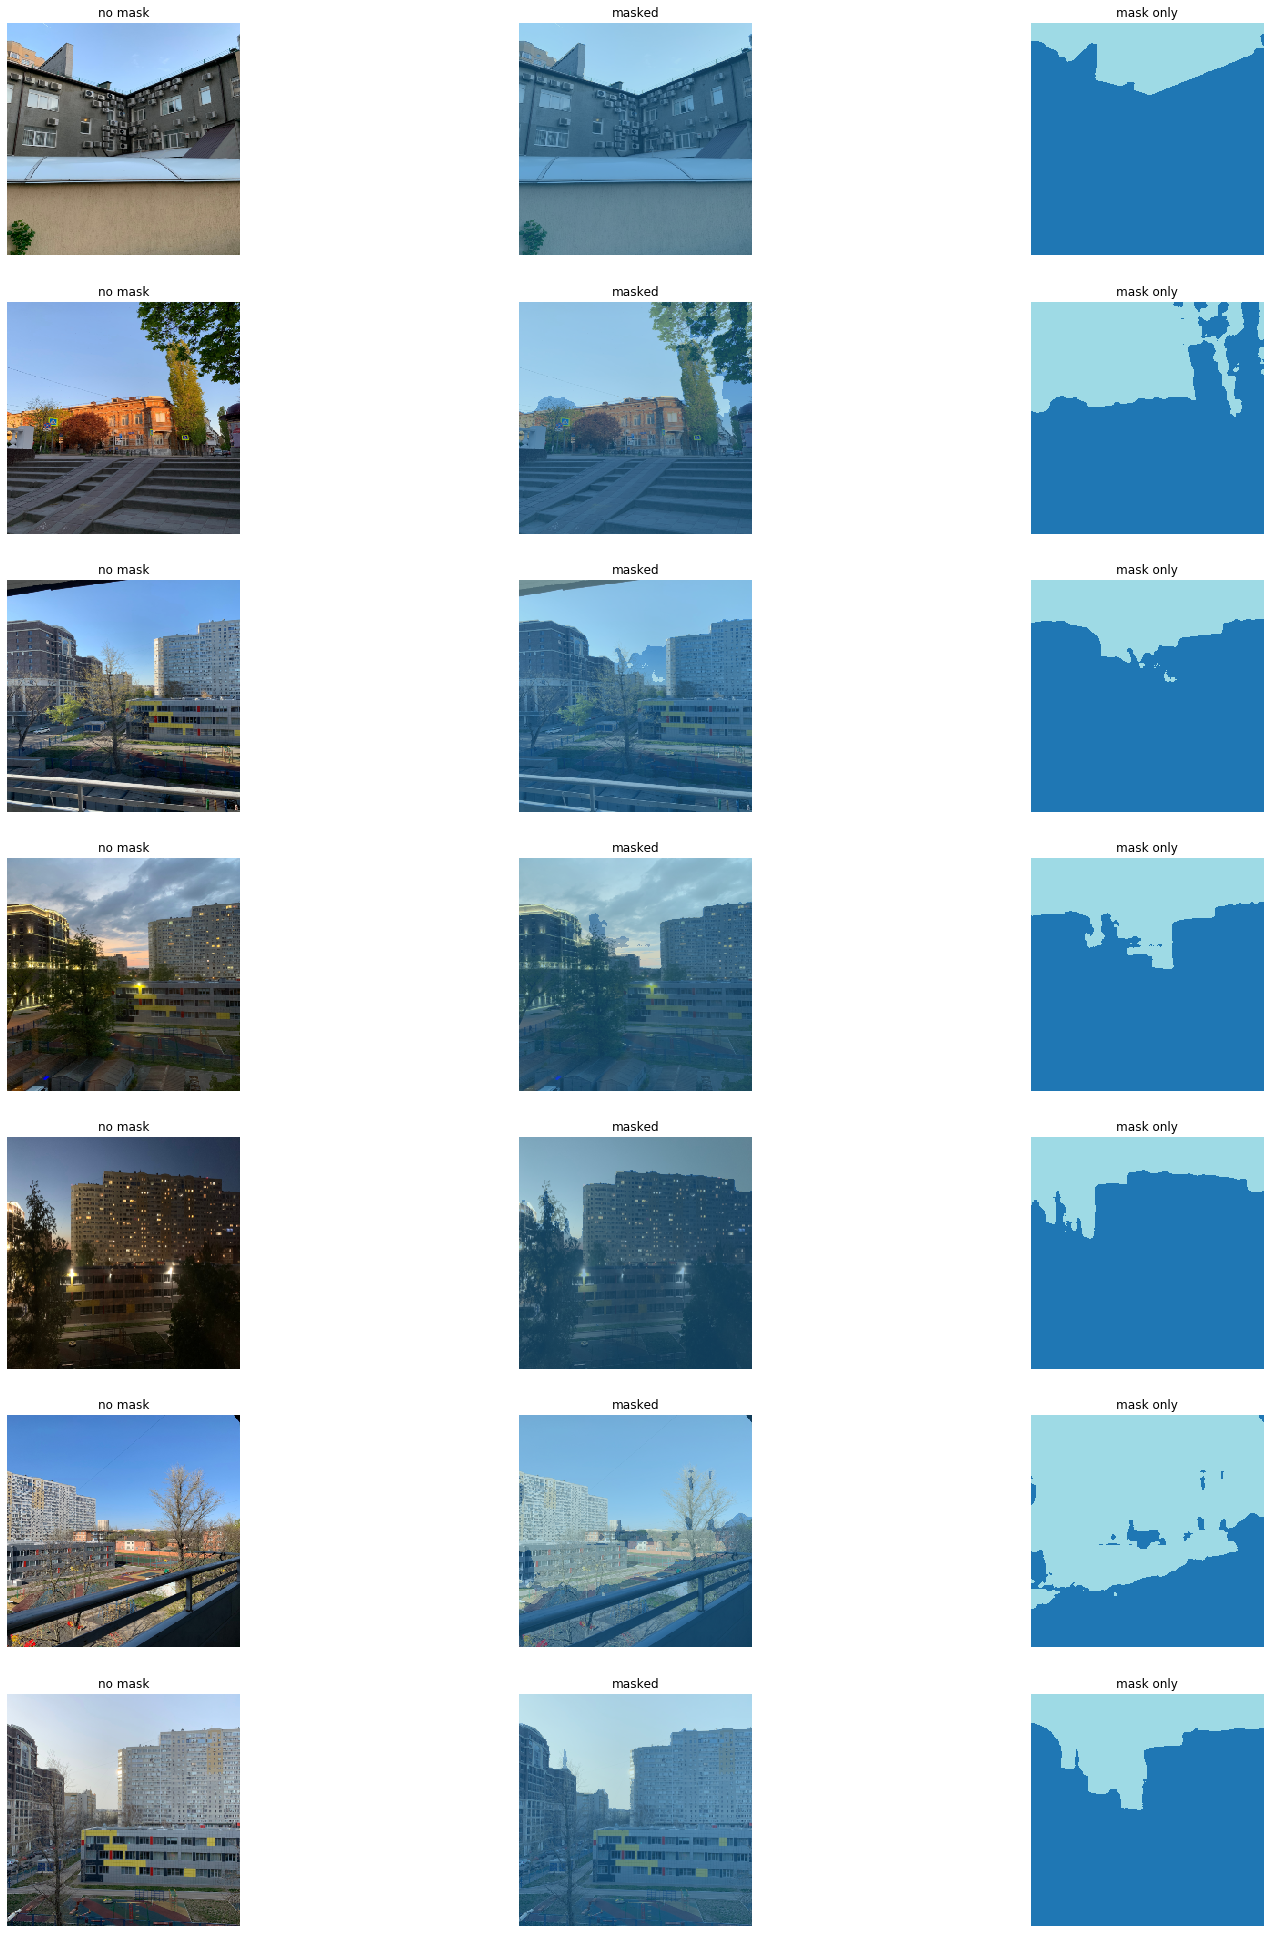

In [5]:
show_results(test_data, learner)

In [6]:
for i, f_map in enumerate(decoder_high_output(3, rescale=True)):
    save_image(f_map.to(float), 
               "/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/pre_classified_output/decoder_high/{}_mask.png".format(i))
    
for i, f_map in enumerate(decoder_middle_output(3, rescale=True)):
    save_image(f_map.to(float), 
               "/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/pre_classified_output/decoder_middle/{}_mask.png".format(i))
    
for i, f_map in enumerate(decoder_first_output(3, rescale=True)):
    save_image(f_map.to(float), 
               "/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/pre_classified_output/decoder_first/{}_mask.png".format(i))
    
for i, f_map in enumerate(encoder_low_output(3, rescale=True)):
    save_image(f_map.to(float), 
               "/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/pre_classified_output/encoder_low/{}_mask.png".format(i))
    
for i, f_map in enumerate(encoder_middle_output(3, rescale=True)):
    save_image(f_map.to(float), 
               "/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/pre_classified_output/encoder_middle/{}_mask.png".format(i))
    
for i, f_map in enumerate(encoder_first_output(3, rescale=True)):
    save_image(f_map.to(float), 
               "/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/pre_classified_output/encoder_first/{}_mask.png".format(i))    
    
for i, f_map in enumerate(pre_encoder_output(3, rescale=True)):
    save_image(f_map.to(float),
              "/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/pre_classified_output/pre_encoder/{}_mask.png".format(i))

In [7]:
# Just for fun
image_path = Path("/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/pre_classified_output/decoder_high")
images = list(image_path.glob("*.png"))
image_list = [imageio.imread(image_file) for image_file in images]

imageio.mimwrite("/home/dmitri/Pictures/mask.gif", image_list)

In [8]:
_, raw_mask, se = learner.predict(test_data.test_dl.get(3))
raw_mask *= 255
save_image(raw_mask.to(float), "/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/image_mask.png")

In [33]:
# raw_mask = se.max(dim=0)[1].unsqueeze(0)

In [9]:
AREA_THRESHOLD = 600

lable_np_array = raw_mask.numpy()
    
blur = cv2.GaussianBlur(lable_np_array.astype(np.uint8),(5,5),0).squeeze(0)
ret,thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Contour detection
_, contours, hierarchy = cv2.findContours( thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter contour by area
contour_list = []
area_threshold = AREA_THRESHOLD

for contour in contours:
    area = cv2.contourArea(contour)
    if area > area_threshold :
        contour_list.append(contour)

# Making binary mask by contour        
countMask = np.zeros(thresh.shape, dtype='uint8')
cv2.drawContours(countMask, contour_list, -1, (255, 255, 255), cv2.FILLED)

# Restore accuracy of board between sky and other objects
mask_rev = np.add(cv2.bitwise_not(thresh), cv2.bitwise_not(countMask))
_,mask_rev = cv2.threshold(mask_rev, 0, 255, cv2.THRESH_BINARY)
mask = cv2.bitwise_not(mask_rev) 

save_image(torch.from_numpy(mask).to('cpu', torch.float), "/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/image_mask_after_correction.png")